In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Segmented Image')

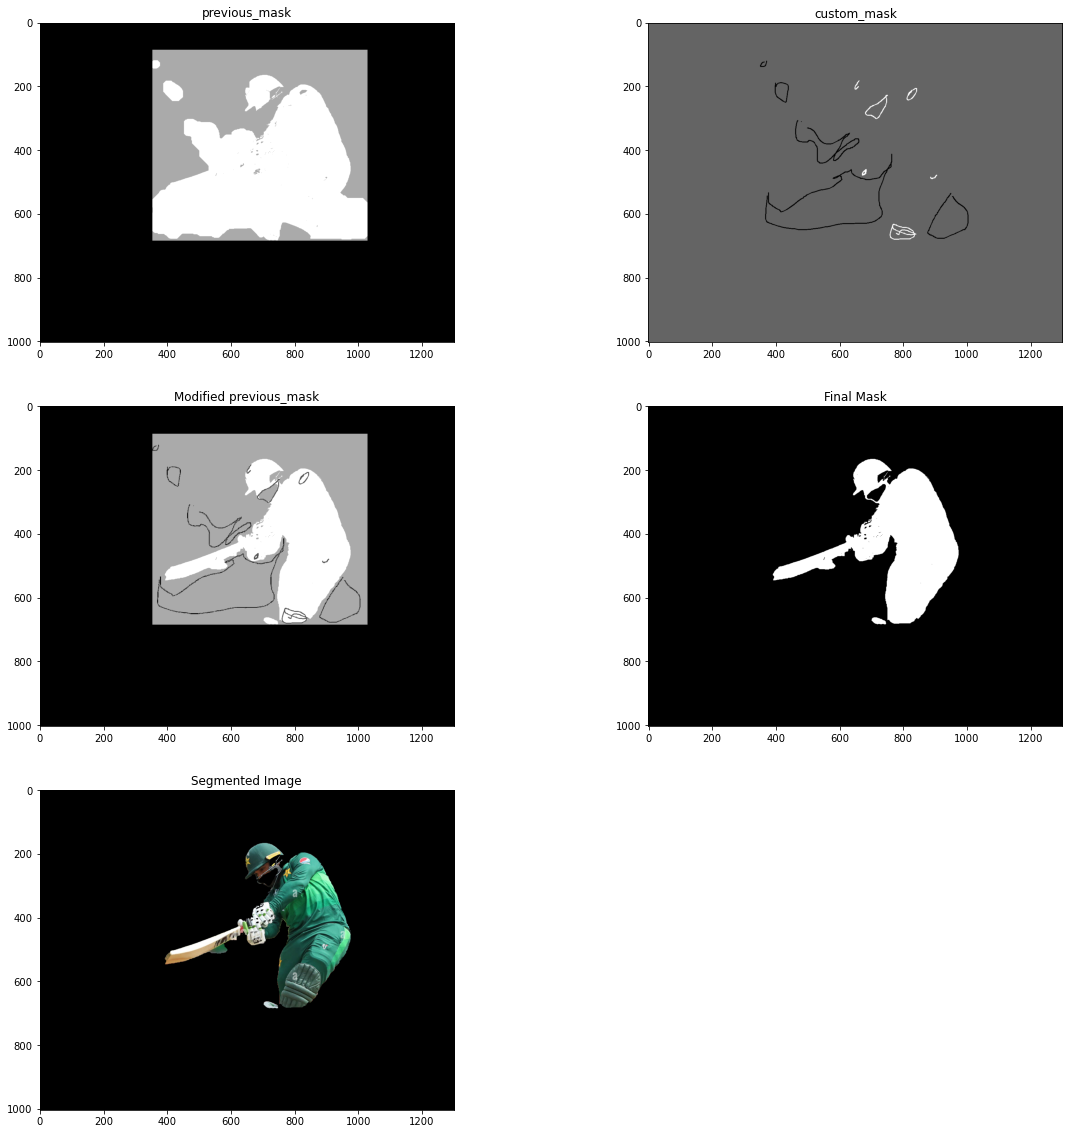

In [44]:
path = 'asif.jpg'
imgorig = cv2.imread(path)
img = imgorig.copy()

img_name = path.split('/')[-1]

# Create an empty mask that will be passed into the grabcut
mask_zeros = np.zeros(img.shape[:2],np.uint8)

# These are temp background and foreground arrays which you have to pass in the grabcut function
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# You can either pass in a fix rectangular coordinates or select them via the selectROI method.
#rect = (50,50,450,290)
r = cv2.selectROI(img)  
rect = (r[0],r[1],r[2],r[3]) 

# Destroy the window you created with selectROI
cv2.destroyAllWindows()

# Apply the grabcut function
initial_mask , bgdModel,fgdModel = cv2.grabCut(img,mask_zeros,rect,bgdModel,fgdModel,2,cv2.GC_INIT_WITH_RECT)

# Convert all probable foreground pixels and foreground pixels to 1 and all the rest to 0
mask = np.where((initial_mask==2)|(initial_mask==0),0,1).astype('uint8')

# Muliply this mask with the original image (but first add an extra channel so sizes are equal)
img = imgorig * mask[:,:,np.newaxis]
cv2.imwrite('mask' + img_name , img)
cv2.imshow("img",img)
k=cv2.waitKey(0)
cv2.destroyAllWindows()
if k==ord("n"):
###################
    while True:
        drawing= False

        cv2.namedWindow('Result',cv2.WINDOW_NORMAL) 

        radius =10
        x1 =None
        x2 =0
        y1 =0
        y2=0
        col = [255,255,255]

        def draw_line(event,x,y,flags,param):
            global x1,y1, x2,y2,drawing

            if event == cv2.EVENT_MOUSEMOVE:
                x2= x
                y2= y       

            if event == cv2.EVENT_LBUTTONDOWN:
                drawing = True
            elif event == cv2.EVENT_LBUTTONUP:
                drawing = False
                x1=None

        basename = 'media/M4/'        
        imgname= 'mask' + img_name       
        img = cv2.imread(imgname)
        imgmask = np.full(img.shape[:2],100, np.uint8)

        cv2.setMouseCallback('Result',draw_line)
        merger = cv2.addWeighted(imgorig, 0.25, img, 0.65, 0.0)

        while True:
            if drawing:   
                if x1 is not None:                  
                    merger = cv2.line(merger, (x1,y1),(x2,y2), col, 2)
                    imgmask = cv2.line(imgmask, (x1,y1),(x2,y2), col, 2)

                    x1= x2
                    y1 = y2
                else:
                    x1,y1 =x2,y2

            # Stack the mask and merged image together.
            mask_3 = cv2.cvtColor(imgmask, cv2.COLOR_GRAY2BGR)    
            stacked = np.hstack(( merger,mask_3))
            cv2.imshow('Result',stacked)


            k= cv2.waitKey(1)
            if k  == ord('c'):
                merger = cv2.addWeighted(imgorig, 0.15, img, 0.85, 0.0)
                imgmask = np.full(img.shape[:2],100, np.uint8)
            elif k  == ord('p'):
                cv2.imwrite('mask' +imgname,imgmask)
                break
            elif k  == ord('a'):
                if col == [255,255,255]:
                    col = [0,0,0]
                else:
                    col = [255,255,255]

            elif k & 0xFF == 27:
                break
        cv2.destroyAllWindows()

    #     plt.figure(figsize=[20,20])
    #     plt.subplot(221);plt.imshow(imgorig[:,:,::-1]);plt.title("Original Image");plt.axis('off');
    #     plt.subplot(222);plt.imshow(initial_mask, cmap = 'gray');plt.title('initial_mask');plt.axis('off');
    #     plt.subplot(223);plt.imshow(mask, cmap = 'gray');plt.title('Final Mask');plt.axis('off');
    #     plt.subplot(224);plt.imshow(img[:,:,::-1]);plt.title("Img after Grabcut");plt.axis('off');

        prev_mask = initial_mask.copy()
        custom_mask = cv2.imread('mask' + imgname ,0)

        # wherever it is marked white (sure foreground), change mask=1
        # wherever it is marked black (sure background), change mask=0
        prev_mask[custom_mask == 0] = 0
        prev_mask[custom_mask > 245] = 1

        new_mask, bgdModel, fgdModel = cv2.grabCut(img,prev_mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

        new_mask_modified = np.where((new_mask==2)|(new_mask==0),0,1).astype('uint8')
        img = imgorig*new_mask_modified [:,:,np.newaxis]
        cv2.imshow('Result',img)
        k= cv2.waitKey(0)
        if k==ord("y"):
            break
cv2.destroyAllWindows()

plt.figure(figsize=[20,20])
plt.subplot(321);plt.imshow(initial_mask.copy(), cmap = 'gray');plt.title('previous_mask')
plt.subplot(322);plt.imshow(custom_mask, cmap = 'gray');plt.title('custom_mask')
plt.subplot(323);plt.imshow(prev_mask, cmap = 'gray');plt.title('Modified previous_mask')
plt.subplot(324);plt.imshow(new_mask_modified, cmap = 'gray');plt.title('Final Mask')
plt.subplot(325);plt.imshow(img[:,:,::-1]);plt.title("Segmented Image")